In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import bt

In [34]:
# Change...
pair = 'BTCUSDT'
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
interval = '1H'
# date to start/end analysis
dt_start_analysis = '2021-8-1'
# Use '' for analysis until now
dt_end_analysis = ''

# Gathering data

In [35]:
from binance_utils import init
from trade_utils import get_data

client = init()
data = get_data(client, pair, interval)

# Target variable

In [36]:
from machine_learning_utils import get_labels_future_returns

data['signal'] = get_labels_future_returns(data[['ClosePrice']].copy())
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume,signal
OpenTime,,,,,,
2021-10-21 03:00:00,64940.17,65195.00,64432.30,65069.02,2351.07654,0
2021-10-21 04:00:00,65069.03,65192.04,64612.00,65042.99,1570.10513,0
2021-10-21 05:00:00,65042.99,65162.00,64800.41,64825.71,1325.62674,0
2021-10-21 06:00:00,64825.72,65024.45,64142.01,64679.39,2332.11889,1
2021-10-21 07:00:00,64677.45,65272.86,64425.19,65100.70,1874.25596,0


# Features

In [37]:
from technical_indicator_utils import get_sma, get_ema, get_macd, get_rsi, get_adx, get_bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous price
data['Returns2'] = data['ClosePrice'].pct_change(2) * 100 # change from 2 previous price
data['Returns5'] = data['ClosePrice'].pct_change(5) * 100 # change from 5 previous price

# Volatility
data['Volatility'] = data.rolling(24, min_periods = 24)['Returns'].std() * 100

data['VolatilityCandle'] = data['HighPrice'] - data['LowPrice']

# SMA
data['SMA5'] = get_sma(data['ClosePrice'], 5)
data['SMA10'] = get_sma(data['ClosePrice'], 10)
data['SMA20'] = get_sma(data['ClosePrice'], 20)
data['SMA30'] = get_sma(data['ClosePrice'], 30)
data['SMA50'] = get_sma(data['ClosePrice'], 50)
data['SMA100'] = get_sma(data['ClosePrice'], 100)
data['SMA200'] = get_sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = get_ema(data['ClosePrice'], 5)
data['EMA10'] = get_ema(data['ClosePrice'], 10)
data['EMA20'] = get_ema(data['ClosePrice'], 20)
data['EMA30'] = get_ema(data['ClosePrice'], 30)
data['EMA50'] = get_ema(data['ClosePrice'], 50)
data['EMA100'] = get_ema(data['ClosePrice'], 100)
data['EMA200'] = get_ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = get_macd(data.ClosePrice)

# RSI
data['RSI'] = get_rsi(data['ClosePrice'])

# ADX
data['DI+'], data['DI-'], data['ADX'] = get_adx(data['HighPrice'], data['LowPrice'], data['ClosePrice'])

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = get_bbands(data.ClosePrice)

In [38]:
# limit data model
if dt_end_analysis == '':
    data = data[dt_start_analysis:]
else:
    data = data[dt_start_analysis:dt_end_analysis]

# Drop the missing values
data.dropna(inplace=True)

# Create X and y

In [39]:
# Target
y = data[['signal']].copy()

# Features
X = data[['Returns', 'Returns2', 'Returns5', 'Volatility', 'VolatilityCandle', 'Volume',
        #'SMA5', 'SMA10', 'SMA20', 'SMA30', 'SMA50', 'SMA100', 'SMA200',
        #'EMA5', 'EMA10', 'EMA20', 'EMA30', 'EMA50', 'EMA100', 'EMA200',
       'MACD', 'MACDSignal', 'MACDHist',
       'RSI', 'DI+', 'DI-', 'ADX',
       'UpperBBand', 'MidiBBand', 'LowerBBand']].copy()

## Sationary check

In [40]:
from machine_learning_utils import is_stationary

# Check for stationarity
for col in X.columns:
    if not is_stationary(data[col]):
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Returns is stationary.
Returns2 is stationary.
Returns5 is stationary.
Volatility is stationary.
VolatilityCandle is stationary.
Volume is stationary.
MACD is stationary.
MACDSignal is stationary.
MACDHist is stationary.
RSI is stationary.
DI+ is stationary.
DI- is stationary.
ADX is stationary.
UpperBBand is not stationary. Dropping it.
MidiBBand is not stationary. Dropping it.
LowerBBand is not stationary. Dropping it.


## Correlation check

In [41]:
from machine_learning_utils import get_pair_above_threshold

print(get_pair_above_threshold(X, 0.7))

MultiIndex([(   'MACD', 'MACDSignal'),
            (   'MACD',        'RSI'),
            (    'RSI',        'DI+'),
            (    'DI+',        'DI-'),
            (   'MACD',        'DI+'),
            ('Returns',   'Returns2'),
            (    'RSI',        'DI-')],
           )


In [42]:
# Drop the highly correlated column
X = X.drop(columns=['MACDSignal'], axis=1)
X = X.drop(columns=['DI+'], axis=1)
X = X.drop(columns=['DI-'], axis=1)
X = X.drop(columns=['VolatilityCandle'], axis=1)
X = X.drop(columns=['Returns2'], axis=1)

In [43]:
X.head()

,Returns,Returns5,Volatility,Volume,MACD,MACDHist,RSI,ADX
OpenTime,,,,,,,,
2021-08-01 00:00:00,0.664563,1.050126,46.951524,2544.490704,232.182549,-43.138321,57.73,22.971196
2021-08-01 01:00:00,-0.072237,0.472404,46.787005,1613.007499,225.909389,-39.529186,57.09,21.834404
2021-08-01 02:00:00,0.242236,-0.366094,47.102841,1202.264039,226.479427,-31.167318,58.73,20.747239
2021-08-01 03:00:00,1.499417,1.364445,55.723125,4175.857843,274.352597,13.364682,67.12,21.530940
2021-08-01 04:00:00,-0.889216,1.437370,59.022505,2197.334549,278.632345,14.115543,59.30,22.258662


# Train-test split

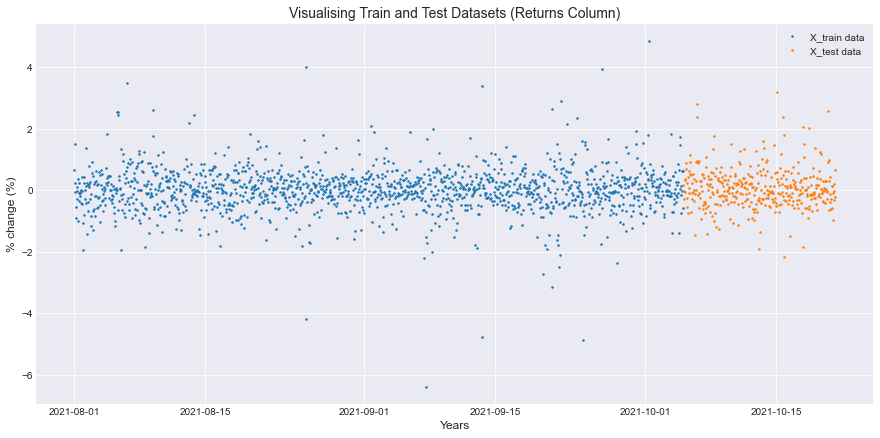

In [44]:
# Obtain the features and target for the 'train_data' and 'test_data' without shuffling
# shuffle is not correct to use in time-series analysis because the order of data is crucial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['Returns'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['Returns'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (Returns Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

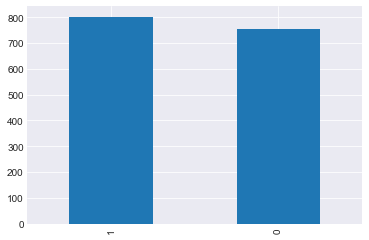

In [45]:
y_train.signal.value_counts().plot(kind='bar')
#plt.xticks(rotation=45)
plt.show()

# Machine Learning classification and forecasting

In [46]:
# Create the machine learning model
rf_model = RandomForestClassifier(
    n_estimators=3, max_features=3, max_depth=2, random_state=4)

# Fit the model on the training data
rf_model.fit(X_train, y_train['signal'])

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=3,
                       random_state=4)

In [47]:
lg_model = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
lg_model.fit(X_train, y_train['signal'])

LogisticRegression(class_weight='balanced', max_iter=10000)

## Forecast data

In [48]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day

,Returns,Returns5,Volatility,Volume,MACD,MACDHist,RSI,ADX
OpenTime,,,,,,,,
2021-10-05 02:00:00,0.166095,0.804786,67.310156,1259.79109,383.193947,83.338916,62.12,20.533483


In [49]:
# choose model to evaluate
model = rf_model

# Get the prediction of a single day
single_day_prediction = model.predict(unseen_data_single_day)

# Preview the prediction
single_day_prediction

array([0])

In [50]:
# Use the model and predict the values for the test data
y_pred = model.predict(X_test)

# Display the first five predictions
print("The first five predicted values", y_pred[:5])

The first five predicted values [0 0 1 0 0]


# Metrics

## Accuracy

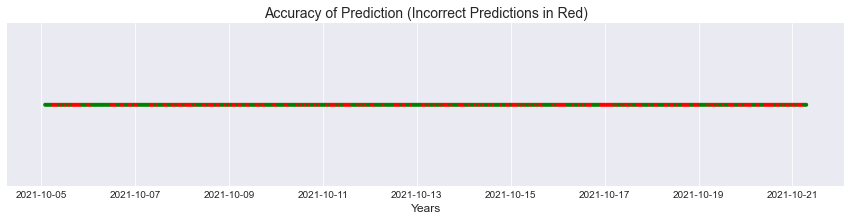

The accuracy is 51.28%.


In [51]:
# Define the accuracy data
y_test_values = y_test['signal'].values
accuracy_data = (y_pred == y_test_values)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 3))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
plt.scatter(x=y_test.index, y=[1]*len(y_test),
            c=(accuracy_data != True).astype(float), marker='.', cmap=cmap)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")

## Confusion Matrix

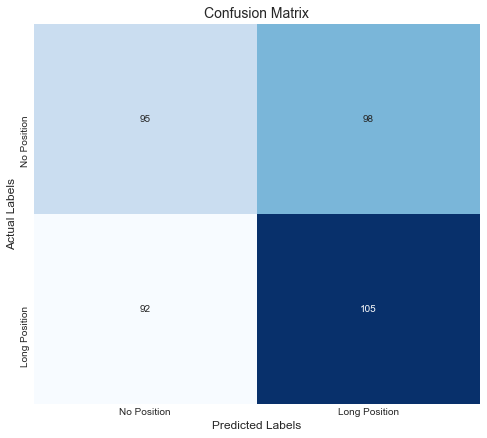

In [52]:
# Define the confusion matrix
confusion_matrix_data = confusion_matrix(y_test_values, y_pred)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d",
            cmap='Blues', cbar=False, annot=True, ax=ax)

# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

# Display the plot
plt.show()

## Classification report

In [53]:
# Classification report
classification_report_data = classification_report(y_test_values, y_pred)

# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       193
           1       0.52      0.53      0.53       197

    accuracy                           0.51       390
   macro avg       0.51      0.51      0.51       390
weighted avg       0.51      0.51      0.51       390



# Strategy backtesting

In [54]:
strategy_data = pd.DataFrame(index=y_test.index, columns = ['ClosePrice', 'signal'])
strategy_data['signal'] = y_pred
strategy_data['ClosePrice'] = data.loc[strategy_data.index]['ClosePrice']
strategy_data.head()

,ClosePrice,signal
OpenTime,,
2021-10-05 02:00:00,49324.82,0
2021-10-05 03:00:00,49306.68,0
2021-10-05 04:00:00,49168.31,1
2021-10-05 05:00:00,49325.00,0
2021-10-05 06:00:00,49295.92,0


## Strategy returns

In [55]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['ClosePrice'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,ClosePrice,signal,pct_change,strategy_returns
OpenTime,,,,
2021-10-05 03:00:00,49306.68,0,-0.000368,-0.000000
2021-10-05 04:00:00,49168.31,1,-0.002806,-0.000000
2021-10-05 05:00:00,49325.00,0,0.003187,0.003187
2021-10-05 06:00:00,49295.92,0,-0.000590,-0.000000
2021-10-05 07:00:00,49476.51,0,0.003663,0.000000


## Equity Curve

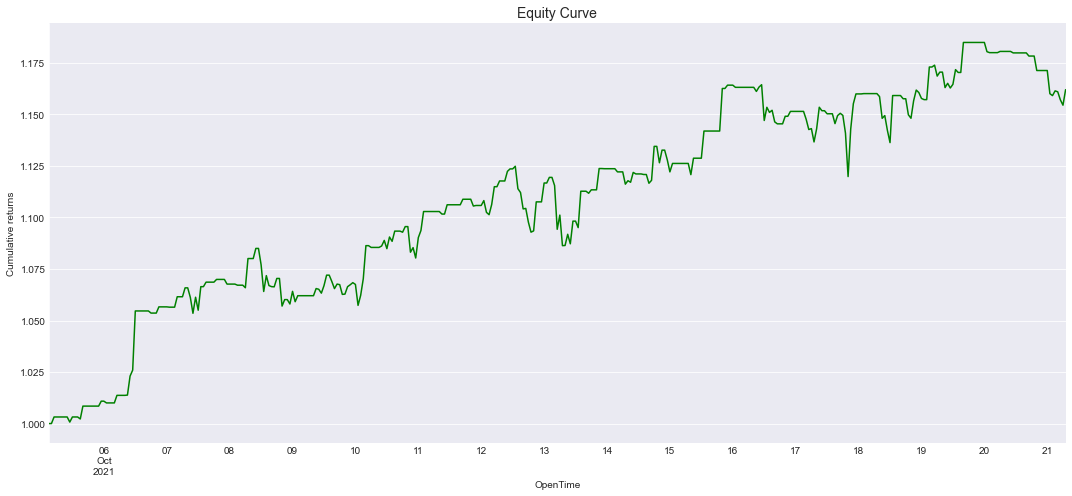

The cumulative return is 16.20%.


In [56]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (
    1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

In [57]:
# For 1H strategy, year = 8760
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (8760/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 2840.28%.


In [58]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    8760) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 43.39%.


The maximum drawdown is -3.83%.


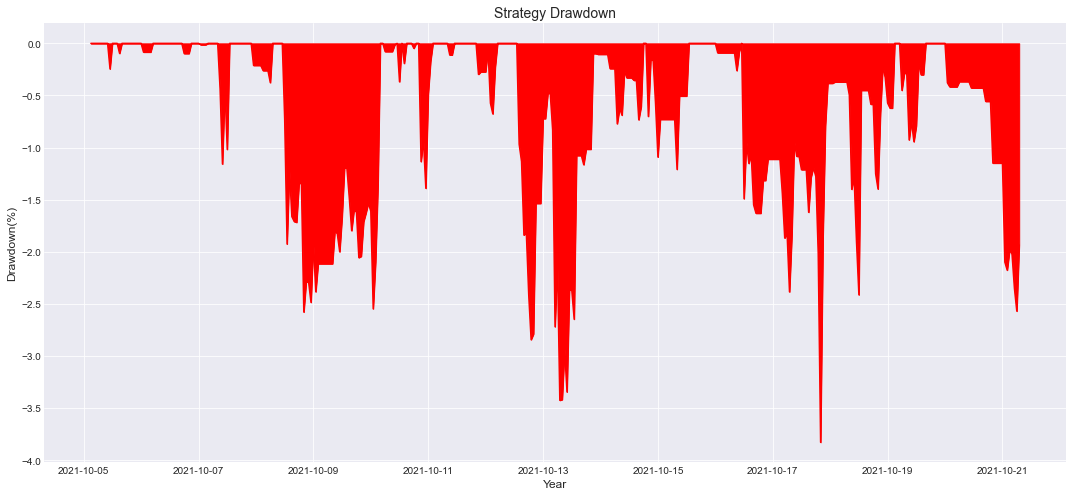

In [59]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

In [60]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(8760), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 8.01.


## Strategy backtest using bt package

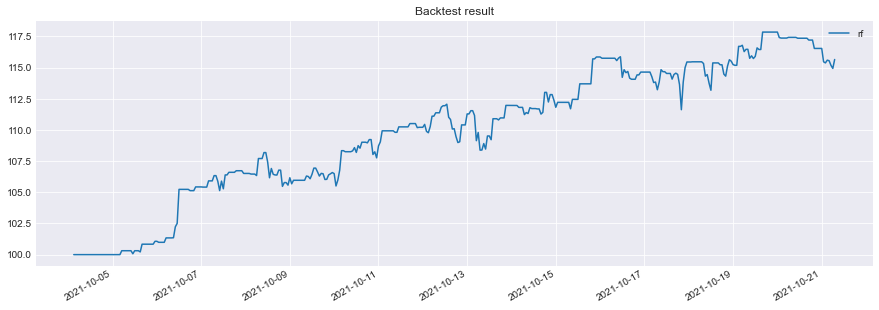

In [61]:
from backtest_utils import signal_strategy

# Get the price data
price_data = strategy_data[['ClosePrice']].copy()
bt_strategy = signal_strategy(strategy_data[['ClosePrice']].copy(), strategy_data[['signal']].copy(), 'rf')

bt_result = bt.run(bt_strategy)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [62]:
bt_result.display()

Stat                 rf
-------------------  ----------
Start                2021-10-04
End                  2021-10-21
Risk-free rate       0.00%

Total Return         15.65%
Daily Sharpe         9.30
Daily Sortino        32.76
CAGR                 2173.45%
Max Drawdown         -1.87%
Calmar Ratio         1165.12

MTD                  15.65%
3m                   -
6m                   -
YTD                  15.65%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  2173.45%

Daily Sharpe         9.30
Daily Sortino        32.76
Daily Mean (ann.)    219.03%
Daily Vol (ann.)     23.56%
Daily Skew           0.67
Daily Kurt           0.41
Best Day             4.31%
Worst Day            -1.11%

Monthly Sharpe       -
Monthly Sortino      -
Monthly Mean (ann.)  -
Monthly Vol (ann.)   -
Monthly Skew         -
Monthly Kurt         -
Best Month           -
Worst Month          -

Yearly Sharpe        -
Yearly Sortino       -
Yearly Me